In [1]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from utilities.basic import list_subdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json

In [18]:
data_dir = join(base_dir, 'data')
tables_dir = join(data_dir, 'tables')
data_long_dir = join(data_dir, 't1_longitudinal')
disk_dir = "F:\\"
br_df = pd.read_csv(join(disk_dir,"CoBra\\Data\\volume_longitudinal_nii\\Brain_Regions.csv"))
pred_dir = join(disk_dir, "CoBra\\Data\\volume_longitudinal_nii\\prediction")
    
pred_df = pd.read_feather(join(data_long_dir, 'results', 'volume_prediction_results.feather'))
with open(join(data_long_dir, "sids_long_new.pkl"), 'rb') as f:
    long_sids_ls = pickle.load(f)
with open(join(data_long_dir, "sids_long_stroke.pkl"), 'rb') as f:
    stroke_sids_ls = pickle.load(f)
with open(join(tables_dir, 'newIDs_dic.pkl'), 'rb') as f:
    id_dic = pickle.load(f)
with open(join(data_long_dir, "sids_long_new.pkl"), 'rb') as f:
    sids_ls = pickle.load(f)
with open(join(tables_dir, "disk_series_directories.json"), 'rb') as f:
    dir_dic = json.load(f)
inv_id_map = {v: k for k, v in id_dic.items()}
#dcm_dirs = {newid:os.path.normpath(dir_dic[inv_id_map[newid]]) for newid in newids}

df = pred_df[pred_df.SeriesInstanceUID.isin(long_sids_ls)]
corrected_outliers = ['109983', '047205', '083072', '109644', '287546']

In [17]:
#pred_df = pred_df[~pred_df.newID.isin(corrected_outliers)]
#pred_df = pred_df.reset_index(drop=True)
#pred_df.to_feather(join(data_long_dir,'results', 'volume_prediction_results.feather'))

## Segmented brain regions

In [3]:
print(list(df.keys()))

['newID', 'SeriesInstanceUID', 'External_CSF', 'Third_Ventricle', 'Right_Inferior_Lateral_Ventricle', 'Right_Lateral_Ventricle', 'Left_Inferior_Lateral_Ventricle', 'Left_Lateral_Ventricle', 'Right_Accumbens_Area', 'Right_Caudate', 'Right_Putamen', 'Right_Pallidum', 'Right_Thalamus_Proper', 'Right_Ventral_DC', 'Right_Basal_Forebrain', 'Left_Accumbens_Area', 'Left_Caudate', 'Left_Putamen', 'Left_Pallidum', 'Left_Thalamus_Proper', 'Left_Ventral_DC', 'Left_Basal_Forebrain', 'Right_Amygdala', 'Right_Hippocampus', 'Right_Entorhinal_Area', 'Right_Fusiform_Gyrus', 'Right_Parahippocampal_Gyrus', 'Right_Inferior_Temporal_Gyrus', 'Right_Middle_Temporal_Gyrus', 'Right_Superior_Temporal_Gyrus', 'Right_Planum_Polare', 'Right_Planum_Temporale', 'Right_Transverse_Temporal_Gyrus', 'Right_Temporal_Pole', 'Right_Anterior_Cingulate_Gyrus', 'Right_Middle_Cingulate_Gyrus', 'Right_Posterior_Cingulate_Gyrus', 'Right_Anterior_Insula', 'Right_Posterior_Insula', 'Right_Anterior_Orbital_Gyrus', 'Right_Lateral_Orb

## Whole brain volume dist

<AxesSubplot:ylabel='Whole_Brain'>

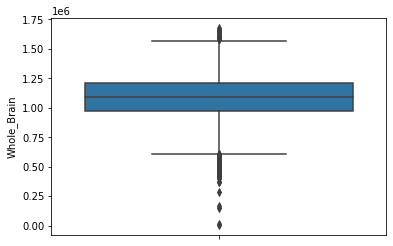

In [20]:
sns.boxplot(data = df, y='Whole_Brain')

## Outliers

In [24]:
wb_outliers_df = pred_df[np.abs(stats.zscore(pred_df.Whole_Brain)) > 3.5]
outliers_ids = list(wb_outliers_df.newID)


corr_sids_ls = [inv_id_map[id] for id in outliers_ids]
dcm_dirs = {sid:os.path.normpath(dir_dic[sid]) for sid in corr_sids_ls}
outliers_sids = [inv_id_map[id] for id in outliers_ids]
print(outliers_ids)
print(outliers_sids)

['003310', '023797', '028822', '036992', '039377', '039378', '039383', '039384', '039386', '039388', '039389', '039392', '039399', '039400', '046860', '052554', '069722', '078055', '078061', '078075', '078078', '078079', '078080', '078081', '096817', '110281', '139292', '141100', '141101', '141109', '148503', '148506', '152441', '152451', '152453', '156342', '157464', '159838', '165810', '166953', '177372', '193606', '195115', '197004', '213206', '217372', '217388', '241992', '253193', '253201', '253215', '258387', '258391', '258394', '258397', '258402', '258403', '268291', '269052', '276227', '279660', '284004', '285322', '285325', '285331', '297021', '301624', '306255', '314826', '325178']
['f3365ef7a2c95cebe0d44b231cd6ed28', '03ea24930fc139e8af20bb55db43ab45', '5428d57b6ddea39c8de3f4b83d68a207', '4ef9707affc9b5c54ec00ec15d6b644f', '3ab4be3a2a4042ada27324e235da421f', '3b70f7f01b1728908a80e6019f8ca670', '632eeaf390547dddd11ce7190b50aa66', '6baff7321eee67aec6a4c6667f4fad68', '71d735443

In [22]:
failed_seg_paths = [(join(pred_dir, id+'_1mm.nii.gz'), join(pred_dir, id+'_1mm_seg.nii.gz')) for id in outliers_ids]
with open(join(data_long_dir, "failed_seg.pkl"), 'wb') as f:
    pickle.dump(failed_seg_paths, f)

In [23]:
wb_outliers_stroke_df = wb_outliers_df[wb_outliers_df.SeriesInstanceUID.isin(stroke_ls)]
wb_outliers_stroke_df

NameError: name 'stroke_ls' is not defined